## Front Matter
- Module name/number: Introduction to Programming for Spatial Analysts/CASA0013
- Student ID: 
- Title of briefing: The Challenge of Ghost Hotels in Greater London: Evidence from Airbnb
- Word count for the Executive Briefing:  (including figures)


# Reproducible Analysis
### Preparation
#### install and import packages

In [1]:
# ! pip install gensim

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize # 分词功能
from nltk.corpus import stopwords # 常用的语言资源
from gensim import corpora,models,similarities # 创建词典或语料库；训练 Word2Vec 等模型；计算文档相似性
from geopy.distance import geodesic # 地理空间距离计算
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely import wkt # 处理几何数据
import os
import matplotlib

d:\Python3.10.4\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


#### Prepare data

In [2]:
cols = ['id', 'name', 'description', 'neighborhood_overview', 'host_id','neighbourhood_cleansed', 
        'latitude','longitude', 'room_type', 'price', 'minimum_nights_avg_ntm', 
        'maximum_nights_avg_ntm', 'availability_30','number_of_reviews', 'review_scores_rating', 
        'review_scores_accuracy','calculated_host_listings_count', 'reviews_per_month']

In [ ]:
# cols = ['id', 'host_id', 'description', 'neighbourhood_cleansed', 'latitude', 'longitude','room_type', 
#         'neighborhood_overview', 'price', 'minimum_nights_avg_ntm', 'reviews_per_month',
#         'calculated_host_listings_count']

In [3]:
# 这里的 listings_1.csv 是从 airbnb 网站上下载的 listing.csv.gz 压缩包里的文件
df = pd.read_csv('C:/Users/vicky/CASA/CASA13/Group_project/data/raw/listings_1.csv',encoding='latin1',low_memory=False,usecols=cols)
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")
# df.to_csv('data/raw/2020-08-24-listings.csv', index=False)

Data frame is 96,182 x 18


### Data cleaning
#### Counting Nulls by Column

In [4]:
df.isnull().sum(axis=0).sort_values(ascending=False) # 检查缺失值，统计数量并排序

neighborhood_overview             50521
price                             32977
review_scores_accuracy            24551
review_scores_rating              24533
reviews_per_month                 24533
description                        3419
minimum_nights_avg_ntm                1
maximum_nights_avg_ntm                1
neighbourhood_cleansed                0
latitude                              0
longitude                             0
room_type                             0
name                                  0
availability_30                       0
number_of_reviews                     0
host_id                               0
calculated_host_listings_count        0
id                                    0
dtype: int64

#### Identifying Problem Rows
Firstly, we check for the NaN for "id". From the output of following code, except the items which are Nan, the value of "host_id", "latitude" and "longitude" is strange. Additionally, many other columns are even not the proper data type (eg: neighbourhood_cleansed, minimum_nights_avg_ntm, room_type ). Thus, we can say this two rows are clearly wrong and will be delete diretly.

In [5]:
df.drop(df[df.id.isna()].index.values, axis=0, inplace=True) # inplace=True：直接在原 DataFrame 上修改，不返回副本

Next, we will check for rows that are causing most of the problems. From following code, we find two rows (29989 and 3558) have 10 NaNs. Simultaneously, after deleting rows whose id is NaN, there are exactly ten colunms which have two NaNs separately, so we assume they are in the same rows. The result is verified by outputing the rows whose latitude and longitude is null. Therefore, these two rows which lost much important information are also deleted.

In [6]:
df.isnull().sum(axis=1).sort_values(ascending=False)

35851    6
27285    6
27185    6
39027    6
33848    6
        ..
72210    0
72209    0
45106    0
19536    0
0        0
Length: 96182, dtype: int64

In [7]:
df = df[pd.to_numeric(df['longitude'], errors='coerce').notna()]
df = df[pd.to_numeric(df['latitude'], errors='coerce').notna()]

In [8]:
df.drop(df[df.longitude.isna()].index.values, axis=0, inplace=True)

In [9]:
df.drop(df[df.latitude.isna()].index.values, axis=0, inplace=True)

In [10]:
df.drop(df[df.neighborhood_overview.isna() & df.description.isna()].index.values, axis=0, inplace=True)

In [11]:
print(df.shape[0])

93643


#### Fixing the Remaining Data Issues
Adjust the type and content of the columns for our further calculation.             

In [12]:
# 1. 去掉货币符号并尝试转换为浮点数
df['price'] = df['price'].str.replace('$','').str.strip()  # 去掉"$"并移除多余空格
df['price'] = pd.to_numeric(df['price'], errors='coerce')   # 转换为浮点数，错误值变为NaN

C:\Users\vicky\AppData\Local\Temp\ipykernel_11868\2320743617.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df['price'].str.replace('$','').str.strip()  # 去掉"$"并移除多余空格


In [13]:
df['maximum_nights_avg_ntm'] = pd.to_numeric(df['maximum_nights_avg_ntm'], errors='coerce') 
df['minimum_nights_avg_ntm'] = pd.to_numeric(df['minimum_nights_avg_ntm'], errors='coerce')   # 转换为浮点数，错误值变为NaN
df['reviews_per_month'] = pd.to_numeric(df['reviews_per_month'], errors='coerce') 
df['calculated_host_listings_count'] = pd.to_numeric(df['calculated_host_listings_count'], errors='coerce') 
df['availability_30'] = pd.to_numeric(df['availability_30'], errors='coerce') 
df['number_of_reviews'] = pd.to_numeric(df['number_of_reviews'], errors='coerce') 
df['review_scores_rating'] = pd.to_numeric(df['review_scores_rating'], errors='coerce') 
df['review_scores_accuracy'] = pd.to_numeric(df['review_scores_accuracy'], errors='coerce') 
df['review_scores_accuracy'] = pd.to_numeric(df['review_scores_accuracy'], errors='coerce') 

In [ ]:
# df.minimum_nights_avg_ntm = df.minimum_nights_avg_ntm.astype('float')
# #a value of 3 nights per booking was used if a listing has a lower minimum nights value than 3.
# df.loc[df["minimum_nights_avg_ntm"] < 3, "minimum_nights_avg_ntm"] = 3 #？？
# df['reviews_per_month']=df['reviews_per_month'].fillna(0).astype('float') # fillna(0)缺失值填充为0
# # df[["longitude","latitude"]] = df[["longitude","latitude"]].apply(pd.to_numeric,errors='coerce')
# # use the sum of private and shared rooms as the total rooms owned by host
# df["calculated_host_listings_count"] = df["calculated_host_listings_count"].fillna(0).astype('float')
# df["price"]=df["price"].astype('float')
# # df.loc[条件, 列名列表]

In [14]:
houseList = df.loc[df["room_type"].isin(["Entire home/apt","Private room","Shared room"]),["id","host_id","room_type","description","neighborhood_overview","longitude","latitude","calculated_host_listings_count","neighbourhood_cleansed"]]

In [15]:
print(houseList.shape[0])

93458


In [16]:
houseList.groupby('neighbourhood_cleansed')['room_type'].value_counts()
#df[(df.room_type=='Private room') | (df.room_type=='Shared room')].neighbourhood_cleansed.value_counts()

neighbourhood_cleansed  room_type      
Barking and Dagenham    Private room        382
                        Entire home/apt     305
                        Shared room          10
Barnet                  Entire home/apt    1439
                        Private room        908
                                           ... 
Wandsworth              Private room       1675
                        Shared room          12
Westminster             Entire home/apt    8352
                        Private room       2090
                        Shared room          36
Name: room_type, Length: 98, dtype: int64

In [17]:
# 统计 id 列中重复值的数量
duplicate_count = df['id'].duplicated(keep=False).sum()
print(f"重复的 id 数量: {duplicate_count}")


重复的 id 数量: 0


### Find ghost hotels and rooms
#### Helper methods
if there are same ids in different sublist, merge the sublist

In [18]:
def mergeSubList(initiallist):
    length = len(initiallist)
    for init1 in range(length):
        for init2 in range(init1 + 1, length):
            if initiallist[init1] == [0]:
                break
            if initiallist[init2] == [0]:
                continue
            # to see whether the two sublists have same elements
            x = list(set(initiallist[init1]+initiallist[init2])) # 合并并去重
            y = len(initiallist[init1]) + len(initiallist[init2])  # 合并前的长度              
            if len(x) < y: # 合并后长度 < 合并后长度说明有重复
                initiallist[init2] = [0]
                initiallist[init1] = x
    return initiallist

#### Perform text similarity


In [21]:
# nltk.download('stopwords')
# nltk.download('punkt') 
# nltk.download('punkt_tab')
# read London spatial stopwords
with open('data/London_Spatial_Stopwords_list_1126.CSV', 'r') as f:
    stopWords_london = set(f.read().split())

stopWords = set(stopwords.words('english')) # 获取常见英文词集合（如 "the", "is", "and" 等）,在计算相似度时会被排除

stopWords = stopWords | stopWords_london

# 输出停用词列表以验证
print(stopWords_london)
print(stopWords)

def gensimSimilarities(test, textList): # 测试文本和用于比较的文本
    # if textList only contain one element, we take turns to use the two text as test 
    if len(textList)==1: # 测试文本只有一个词
        # # 互为测试文本进行相似度计算
        sim = [max(gensimilarities(test, textList))]  # 计算相似度
        textList.append(test)  # 添加测试文本到文本列表
        test = textList.pop(0)   # # 将原文本列表中的第一个文本作为测试文本
        sim.append(max(gensimilarities(test, textList))) # 计算相似度
        # use the small one as the similarity
        sim = min(sim) # 取相似度最小值
    else:
        sim = max(gensimilarities(test, textList))
    return sim

def gensimilarities(test,textList): # 相似度计算函数
    # use tf-idf to construst the importance of the words, and use the gensim to calculate the similarity
    allWordsList = []
    # when there are only one element, the function will always return 0
    if len(textList)==1:
        textList.append("0") # 添加一个虚拟文本以避免上述错误
    for text in textList:
        # separate the words and exclude the words in stopwords
        wordsList = [word for word in word_tokenize(text) if word not in stopWords]  # 分词并排除停用词
        allWordsList.append(wordsList)
    # 构建 gensim 的词典和语料库
    dictionary = corpora.Dictionary(allWordsList)
    corpus = [dictionary.doc2bow(wordsList1) for wordsList1 in allWordsList]    
    # 将测试文本转化为 BOW 格式，并过滤停用词
    # BOW 格式是一个列表，列表中的每个元素是一个元组 (word_id, count)
    testWords = dictionary.doc2bow([word for word in word_tokenize(test) if word not in stopWords])
    # # 构建 TF-IDF 模型和相似度索引
    tfidf = models.TfidfModel(corpus)
    index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=len(dictionary.keys()))
    # 计算相似度
    sim = index[tfidf[testWords]]
    return sim

# 以下是测试语句
# test = "This is a test text."
# textList = ["This is another text.", "Completely unrelated content."]
# print(word_tokenize(test))  # 输出分词结果

# similarity = gensimSimilarities(test, textList)
# print(f"Similarity: {similarity}")

{'Hale', 'Greenwich', 'Shoreditch', 'Liverpool', 'Globe', 'Debden', 'Westbourne', 'Bush', 'Angel', 'St.', 'Waterloo', 'Bermondsey', 'Harlesden', 'Latimer', 'Big', 'Redbridge', 'Walthamstow', "Paul's", 'Victoria', 'Hyde', 'Ealing', 'Fulham', 'Hanger', 'Queensbury', 'Shadwell', 'Cockfosters', 'Chiswick', 'Covent', 'Alperton', 'Lancaster', 'London', 'Colindale', 'Buckhurst', 'Hill', "King's", 'Borough', 'Road', 'Putney', 'History', 'Southfields', 'Leytonstone', 'Kensington', 'Canary', 'Market', "Earl's", 'Square', 'Broadway', 'Kenton', 'Woodford', 'Gallery', 'Kennington', 'Royal', 'Upney', 'Seven', 'Lane', 'Chigwell', 'Amersham', 'Queensway', 'North', 'Shard', 'Parsons', 'National', 'Farringdon', 'Charing', 'Colliers', 'Theydon', 'South', 'Cannon', 'Ladbroke', 'Brent', 'City', 'West', 'Bank', 'East', 'Southwark', 'Bethnal', 'Turnpike', 'Gatwick', 'Camden', 'British', 'Dollis', 'Kensal', 'Fairlop', 'Leicester', 'Kilburn', 'Valley', 'White', 'Ickenham', 'Upminster', 'Oxford', 'Elm', 'Plaist

if the item in column "neighborhood_overview" is not null, calculate the similarity based on it. Otherwise calculate the similarity on column "description"

In [22]:
# 定义函数 checkDescription，判断房间描述或邻里信息是否与一组房东房源的描述高度相似
# 如果相似性超过某个阈值（0.5），则将该房间归类为“ghost hotel”。
def checkDescription(checkroom,ghostHotel):
    checkDf = houseList.loc[houseList["id"]==checkroom,["id", "neighborhood_overview","description"]]
    samehostDf = houseList[houseList["id"].isin(ghostHotel)]
    simlarity1 = 0
    simlarity2 = 0 # 初始化相似度
    overviewDf = samehostDf["neighborhood_overview"].dropna()
    checkOverview = checkDf["neighborhood_overview"].dropna() # 提取neighborhood非空值
    if overviewDf.shape[0]>0 and checkOverview.shape[0] > 0:
        simlarity1 = gensimSimilarities(checkOverview.iloc[0],list(overviewDf)) # 两个都非空计算相似度      
    if samehostDf.shape[0] != overviewDf.shape[0]: # 两者行数不同，即有房子缺少neighborhood信息，用 description 补充判断
        descripDf = samehostDf["description"].dropna()
        checkDesc = checkDf["description"].dropna() # 提取description列
        if descripDf.shape[0]>0 and checkDesc.shape[0] > 0: # 两者均非空
            simlarity2 = gensimSimilarities(checkDesc.iloc[0], list(descripDf)) # 计算相似度
    simlarity = max(simlarity1, simlarity2)
    # if the description of checkroom has simlarity bigger than 0.5 of one text of the ghostHotel, 
    # classify it as ghost hotel`
    if simlarity > 0.5:
        return True
    else:
        return False

#### The main part of finding the ghost hotels
Creat a list called ghostlist which contains all the 'id' for ghost rooms, and each sublist of ghostlist is a ghost hotel.

1. 初始化数据和临时行
2. 遍历房源：
   2.1 按房东筛选房源子集
   2.2 如果房东房源数量 <= 1，跳过
   2.3 地理位置分组
   2.4 文本描述分组
   2.5 合并分组，保留有效分组
3. 更新结果（ghostList）和未处理房源索引
4. 删除临时行，清理数据

房源必须满足以下条件才会归为“ghost hotel”：
1. 地理条件：距离小于 200 米。
2. 描述条件：文本描述相似。

In [23]:
indexlist = list(houseList.index)
ghostList = []
# 临时行 ini，防止在数据处理过程中出现空值问题
houseList.loc["ini",["id","host_id","description","neighborhood_overview","longitude","latitude","calculated_host_listings_count"]] = [0,0,"0","0",0,0,0]
while len(indexlist) > 0 : # 只要 indexlist 中还有未处理的房源，就继续循环
    # if one have more than one private or shared rooms on Airbnb, it has the suspicion to be ghost hotels
    if houseList.loc[indexlist[0],"calculated_host_listings_count"] > 1: # 当前房源的房东有多个房源情况
        # find the house which have the same host_id and put them together
        ghostdf = houseList[houseList["host_id"] == houseList.loc[indexlist[0],"host_id"]] # 取出所有与当前房源host_id相同的房源
        ghostHost = list(ghostdf['id']) # 将这些房源的 id 列表存储到 ghostHost
        # it is a list used to store the ghost hotels list
        # 地理位置分组：通过计算地理距离，将距离小于 200 米的房源归为一组
        initiallist = [[0]] # 初始化分组列表
        for i in ghostdf.index: # 遍历房东的所有房源
            # if there are no rooms within the distance it will still be False
            isghost = False
            # 遍历当前已分组的房源，逐个检查是否与当前房源（i）距离接近
            for init in initiallist: # 遍历每个分组
                for ini in init: # 遍历分组内的每个房源
                    # the longitude and latitude of the rooms in list
                    # 筛选id == ini 的行获取经纬度数据
                    iniLogLat = (houseList.loc[houseList["id"]==ini,"longitude"].iloc[0],houseList.loc[houseList["id"]==ini,"latitude"].iloc[0])
                    # 提取ghostdf中索引为 i 的房源经纬度
                    iLonLat = (ghostdf.loc[i,"longitude"],ghostdf.loc[i,"latitude"])
                    # use the longitude and latitude to calculate the distance
                    # 计算两个房源的地理距离，单位为米
                    distance = geodesic(iniLogLat, iLonLat).m
                    # if the distance is less than 200m, we consider it as ghost hotel
                    #(distance of 50 to 500 meters is manually tried and find the optimal one)
                    if distance < 200:
                        init.append(ghostdf.loc[i,"id"]) # 如果距离小于 200 米，将当前房源（i）加入对应分组
                        isghost = True
                        break
            if not isghost:
                initiallist.append([ghostdf.loc[i,"id"]]) # 如果未找到分组，创建新分组
        
        # use the description to calculate the distance, in case of inaccurate positioning 
        # 文本描述分组：通过文本相似度计算，进一步补充分组
        initiallist1 = [[0]]
        for checkroom in ghostHost:
            isghost = False
            for ghostHotel in initiallist1:
                if checkDescription(checkroom,ghostHotel): # 调用 checkDescription 函数计算相似度
                    ghostHotel.append(checkroom) # 相似则加入ghostHotel
                    isghost = True
                    break
            if not isghost: # 如果不相似
                initiallist1.append([checkroom]) # 创建新分组
        initiallist.extend(initiallist1) # 合并地理分组和文本分组
        initiallist = mergeSubList(initiallist) # 合并重叠的分组
        # the list with more than one id is a ghost hotel
        initiallist = [init for init in initiallist if len(init)>1] # 只保留包含多个房源的分组
       
        ghostList.extend(initiallist) # 添加到最终结果列表 ghostList
        # delete the rows that we have already checked
        indexlist = [index for index in indexlist if index not in ghostdf.index] # 更新indexlist，移除 ghostdf.index 中的房源索引
    else: # 房东只有一个房源
        # if the host don't have more than one private or shared rooms, it is not ghost hotels
        del indexlist[0] # 删除房源索引
houseList.drop("ini",inplace=True) # 删除临时行

In [24]:
# 检查每个分组的大小
group_sizes = [len(group) for group in ghostList]
print(f"分组的最小大小: {min(group_sizes)}, 最大大小: {max(group_sizes)}")
print(f"分组大小的分布: {pd.Series(group_sizes).describe()}")
# min:2 max:133

分组的最小大小: 2, 最大大小: 133
分组大小的分布: count    13805.000000
mean         3.610866
std          4.521829
min          2.000000
25%          2.000000
50%          2.000000
75%          4.000000
max        133.000000
dtype: float64


In [25]:
print(len(ghostList)) # 13805

13805


get the complete information of each ghost room

In [26]:
ghostHotelDf = pd.DataFrame(columns = df.columns) # 创建一个空的 Pandas 数据框，列名与原始数据框 df 的列名相同
for rooms in ghostList: # 遍历分组
    # 通过 rooms 中的房源 id，在原始数据框 df 中找到对应的完整信息，汇总到新的数据框 ghostHotelDf 中
    ghostHotelDf = ghostHotelDf._append(df.loc[df["id"].isin(rooms)])

In [27]:
print(ghostHotelDf.shape[0]) # 49848

49848


In [28]:
ghostHotelDf.head()

,id,name,description,neighborhood_overview,host_id,neighbourhood_cleansed,latitude,longitude,room_type,price,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,number_of_reviews,review_scores_rating,review_scores_accuracy,calculated_host_listings_count,reviews_per_month
0,13913,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,54730,Islington,51.56861,-0.1127,Private room,59.0,1.0,29.0,28,44,4.82,4.74,3,0.26
117,89870,London Holiday Flat Let-Islington,My comfortable & bright one bedroom flat has a...,Finsbury Park is a friendly melting pot commun...,54730,Islington,51.56792,-0.11125,Entire home/apt,143.0,2.0,28.0,26,142,4.63,4.67,3,0.89
70989,1021187456703584211,Lovely Art Flat in Finsbury Park,My bright one bedroom flat has a creative vibe...,NaN,54730,Haringey,51.570208,-0.113028,Entire home/apt,143.0,2.0,28.0,26,1,5.0,5.0,3,0.27
2,17402,Fab 3-Bed/2 Bath & Wifi: Trendy W1,"You'll have a great time in this beautiful, cl...","Fitzrovia is a very desirable trendy, arty and...",67564,Westminster,51.52195,-0.14094,Entire home/apt,493.0,3.0,365.0,14,56,4.77,4.83,6,0.34
11,137907,"Elegant Very Central: Fitzrovia W1. King Bed, ...",Clean modern well-equipped apt in very central...,"Location, location, location! You won't find b...",67564,Camden,51.52197,-0.14035,Entire home/apt,NaN,3.0,90.0,23,66,4.68,4.86,6,0.46


In [29]:
# 按 room_type 计数
room_type_counts = ghostHotelDf['room_type'].value_counts()

# 输出计数结果
print(room_type_counts)

# Entire home/apt    32952
# Private room       16709
# Shared room          187

Entire home/apt    32952
Private room       16709
Shared room          187
Name: room_type, dtype: int64


接下来对 ghostHotelDf 进行数据处理

In [30]:
# 发现 ghostHotelDf 中 id 存在重复项，删除重复项
value_counts_id_0 = ghostHotelDf['id'].value_counts()
print(value_counts_id_0[:10])

ghostHotelDf_unique = ghostHotelDf[~ghostHotelDf['id'].duplicated(keep='first')]

value_counts_id_1 = ghostHotelDf_unique['id'].value_counts()
print(value_counts_id_1[:10])

print(f"Data frame is {ghostHotelDf_unique.shape[0]:,} x {ghostHotelDf_unique.shape[1]}")

1204356542695025693    3
1001237313264887178    3
999862244778649601     3
989689952215921702     3
933923565179215342     3
1052077090045831258    2
566805390884146315     2
958694271102765230     2
846399719015355895     2
755842495167497684     2
Name: id, dtype: int64
13913                  1
734978777366155985     1
1193192055602236537    1
1197265037390466361    1
1197280659877132493    1
1197272104905756714    1
733072488290688498     1
841402606386012451     1
734882919047234003     1
963834420525278055     1
Name: id, dtype: int64
Data frame is 43,584 x 18


发现有些房主具有多个房源（可能是代理商），根据可视化结果，需要删除 房源数目>7 的数据

314162972    437
33889201     393
28820321     267
1432477      256
156158778    207
269308503    183
48165024     166
124359784    127
215357262    125
228928499    124
Name: host_id, dtype: int64
2      5239
3      1354
4       820
5       427
6       279
       ... 
207       1
256       1
267       1
393       1
437       1
Name: host_id, Length: 89, dtype: int64


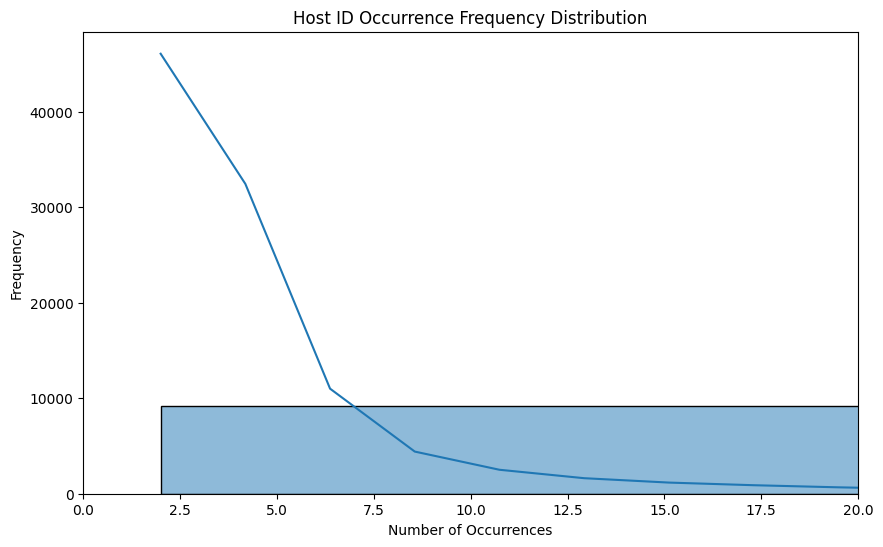

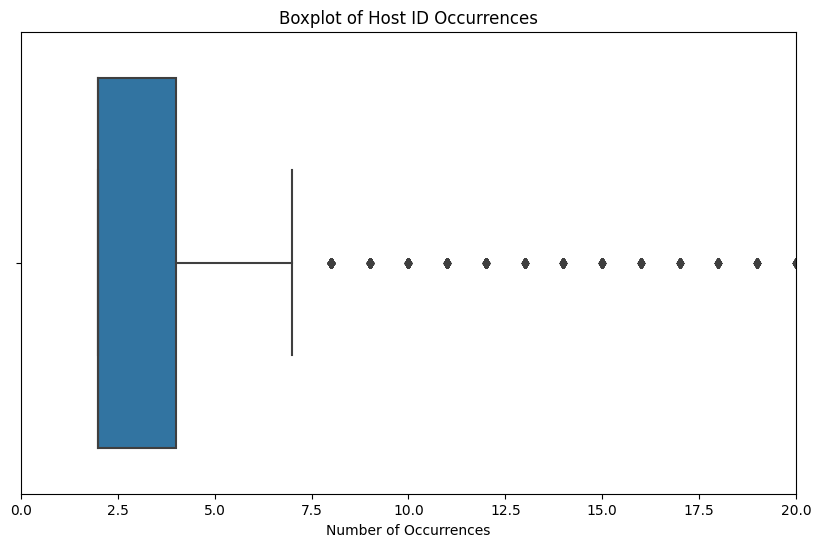

In [31]:
# 检查有多个房源的 host_id
value_counts_host_id_0 = ghostHotelDf_unique['host_id'].value_counts()
print(value_counts_host_id_0[:10])

# 检查 每个房东拥有多少套房源 出现的次数
frequency_counts = value_counts_host_id_0.value_counts()
sorted_frequency_counts = frequency_counts.sort_index()
#print(sorted_frequency_counts[:50])
print(sorted_frequency_counts)

# 绘制出现次数的直方图
plt.figure(figsize=(10, 6))
sns.histplot(value_counts_host_id_0, bins=15, kde=True)
plt.title("Host ID Occurrence Frequency Distribution")
plt.xlabel("Number of Occurrences")
plt.ylabel("Frequency")
plt.xlim(0, 20)
plt.show()

# 绘制箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(x=value_counts_host_id_0)
plt.title("Boxplot of Host ID Occurrences")
plt.xlabel("Number of Occurrences")
plt.xlim(0, 20)
plt.show()


In [32]:
# 筛选出 calculated_host_listings_count大于7 的host_id
hosts_to_remove = ghostHotelDf_unique.loc[ghostHotelDf_unique['calculated_host_listings_count'] > 7, 'host_id'].unique()

# 从原数据中删除这些host_id对应的行，得到最终结果 ghostHotelDf_filtered
ghostHotelDf_filtered = ghostHotelDf_unique[~ghostHotelDf_unique['host_id'].isin(hosts_to_remove)]

# 打印结果
print(f"Original DataFrame Shape: {ghostHotelDf_unique.shape}")
print(f"Filtered DataFrame Shape: {ghostHotelDf_filtered.shape}")

# 检查结果是否符合条件
print("Host IDs removed:", hosts_to_remove)

Original DataFrame Shape: (43584, 18)
Filtered DataFrame Shape: (22276, 18)
Host IDs removed: [133271 813141 460272 ... 226865991 593136228 495838399]


In [33]:
#ghostHotelDf_filtered.to_csv('ghostHotelDf_filtered.csv', index=False)

### Visualization part
Plot a stacked figure to show the Composition of Listings in Airbnb.For each borough, the top of each color is the number of its corresponding type of lstings.
#### Composition of airbnb listings with respect yo ghost hotel

In [50]:
number1Df = pd.DataFrame(df["neighbourhood_cleansed"].value_counts()) # 按区域统计房源数
number2Df = pd.DataFrame(houseList["neighbourhood_cleansed"].value_counts()) # 按区域统计私人房源和共享房源数量
number3Df = pd.DataFrame(ghostHotelDf_filtered["neighbourhood_cleansed"].value_counts()) # 按区域统计“ghost hotel”房源数
numberDf = pd.merge(number1Df, number2Df, how='outer',left_index=True,right_index=True)
numberDf = pd.merge(numberDf, number3Df, how='outer',left_index=True,right_index=True) # 合并三个统计结果
numberDf.columns = ["total listings","private/shared rooms","ghost hotels"] # 命名列
numberDf = numberDf.fillna(0) # 将 NaN 值填补为 0

numberDf.head()

,total listings,private/shared rooms,ghost hotels
neighbourhood_cleansed,,,
Barking and Dagenham,697,697,220
Barnet,2366,2365,630
Bexley,553,553,181
Brent,2921,2921,730
Bromley,866,866,202


In [51]:
def stackFigure():
    sns.set_style("white")
    sns.set_context({"figure.figsize": (18, 10)})
    sns.barplot(x = numberDf.index, y = numberDf["total listings"], color = "yellow")
    sns.barplot(x = numberDf.index, y = numberDf["private/shared rooms"], color = "blue")
    ghost_plot = sns.barplot(x = numberDf.index, y = numberDf["ghost hotels"], color = "red")

    raw_data_legend = plt.Rectangle((0,0),1,1,fc="yellow", edgecolor = 'none')
    private_room_legend = plt.Rectangle((0,0),2,1,fc='blue',  edgecolor = 'none')
    ghost_hotel_legend = plt.Rectangle((0,0),1,1,fc='red',  edgecolor = 'none')
    font = {'weight' : 'normal','size': 20}
    l = plt.legend([raw_data_legend, private_room_legend, ghost_hotel_legend], ["total listings", "private/shared rooms","ghost hotel rooms"], ncol = 1, prop={'size':16},loc='upper left')
    ghost_plot.set_ylabel("The Amount of Rooms",font)
    ghost_plot.set_title("Figure 1: The Composition of Listings on Airbnb of 33 Boroughs in London",fontsize=25)
    plt.yticks(fontsize= 10)
    plt.xticks(rotation=-90, fontsize=14)
    plt.show()

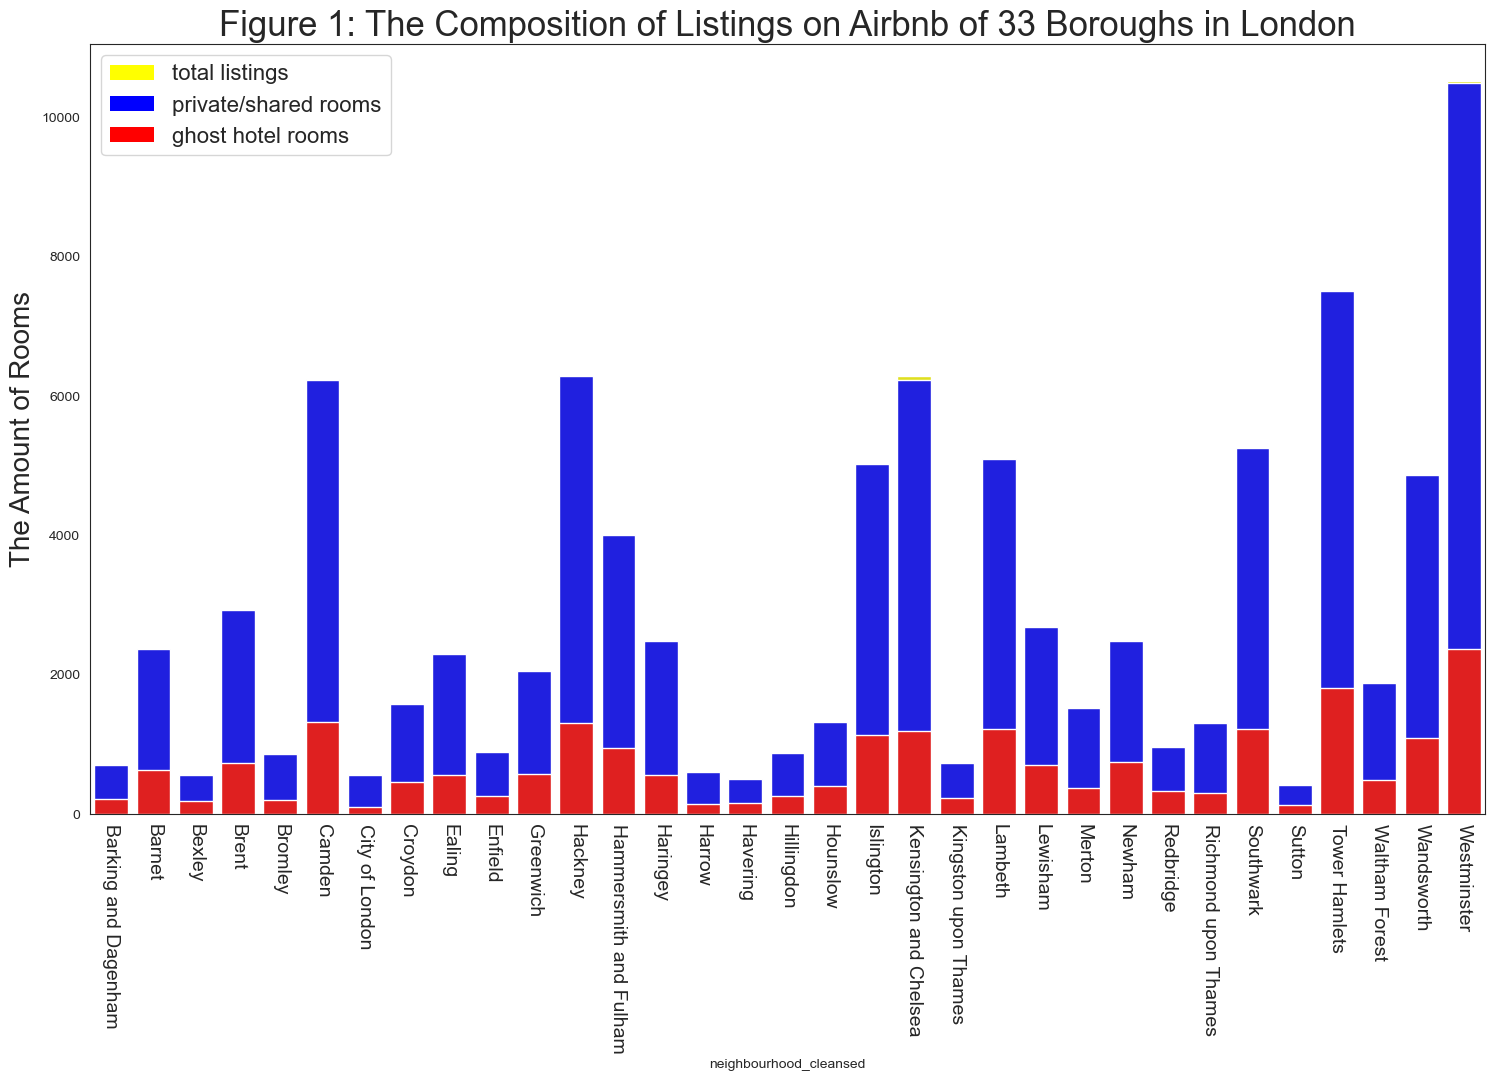

In [52]:
stackFigure()


Compares the `id` column in `ghostHotelDf_filtered` with the `id` column in `df`. If they match, the newly created is_it_gh column in the `airbnb_gh_final` dataframe will be marked as 1.

In [ ]:
airbnb_gh_final = df.copy()

# initialise a new column 'is_it_gh', with a default value of 0
airbnb_gh_final['is_it_gh'] = 0

gh_ids = set(ghostHotelDf_filtered['id'])
# Loop through the `df` columns to see if the 'id' column in `df` exists in the 'id' column in `ghostHotelDf_filtered`
for i in range(len(airbnb_gh_final)):
    if airbnb_gh_final.loc[i, 'id'] in gh_ids:
        airbnb_gh_final.loc[i, 'is_it_gh'] = 1

print(f"Data frame is {airbnb_gh_final.shape[0]:,} x {airbnb_gh_final.shape[1]}")
print(airbnb_gh_final.head(10))

#### Overview: The Distribution of Ghost Hotels' Proportion in Total Airbnbs for Each Borough.

In [ ]:
# Count the number of ghost hotels and all airbnbs
summary = airbnb_gh_final.groupby('neighbourhood_cleansed').agg(
    total_listings=('is_it_gh', 'count'),
    ghost_hotels=('is_it_gh', 'sum')).reset_index()

# Calculate the percentage of ghost hotels in all airbnbs
summary['ghost_hotel_percentage'] = (summary['ghost_hotels'] / summary['total_listings']) * 100

summary.head()

In [ ]:
# read in Geopackage file and check the crs
url_boros = "https://raw.githubusercontent.com/Cihshee/CASA0013_BugAvenger/main/data/Boroughs.gpkg"
boros = gpd.read_file(url_boros)
print(boros.crs) 
boros.head()

# merge the dataframes on borough name and create a new dataframe `boros_ghproportion` for plotting
boros_ghproportion = boros.merge(summary, how='left', left_on='NAME', right_on='neighbourhood_cleansed')
boros_ghproportion.head()

In [ ]:
def ghProportionPlot():
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    boros_ghproportion.plot(edgecolor=(1, 1, 1, 1),linewidth=1, column='ghost_hotel_percentage',cmap='Blues',
                            legend=True,legend_kwds={'label': "Ghost Hotel Percentage (%)"},ax=ax)
    for idx, row in boros_proportion.iterrows():
        centroid = row['geometry'].centroid
        ax.text(
            centroid.x, centroid.y,
            row['NAME'],
            fontsize=6,
            ha='center',
            va='center',
            color='black')
    
    ax.set_title("Figure 2: The distribution of Ghost Hotels'Proportion \nin total airbnbs for each borough", fontsize=16)
    ax.axis('off')
    plt.show()

In [ ]:
ghProportionPlot()

#### Ghost Hotel's Impact on Other Airbnbs: Study by Revenue Share

In [ ]:
def calculate_revenue(dataframe):
    """
    Calculate the income for each record in a single data frame
    """
    price = dataframe['price']
    day_not_availablity = 30 - dataframe['availability_30']
    revenue = price * day_not_availablity
    return revenue

def revenue_by_borough(dataframe):
    """
    Calculate total revenue by partition
    
    Parameters:
    - dataframe: pandas dataframe containing `neighbourhood_cleansed`, `price`, and `availability_30` columns
    
    Returns:
    - revenue_summary: revenue summary for each partition
    """
    dataframe.loc[:,'revenue'] = calculate_revenue(dataframe)
    revenue_summary = dataframe.groupby('neighbourhood_cleansed')['revenue'].sum().reset_index()
    revenue_summary.columns = ['borough', 'revenue']
    return revenue_summary

total_revenue_summary = revenue_by_borough(airbnb_gh_final)
ghost_hotel_revenue_summary = revenue_by_borough(airbnb_gh_final[airbnb_gh_final['is_it_gh'] == 1])

revenue_summary = total_revenue_summary.merge(
    ghost_hotel_revenue_summary,
    on='borough',
    how='left',
    suffixes=('_total', '_ghost')
)

revenue_summary['ghost_revenue_proportion'] = revenue_summary['revenue_ghost'] / revenue_summary['revenue_total'] * 100
revenue_summary.head()

boros_ghrv = boros.merge(revenue_summary, how='left', left_on='NAME', right_on='borough')

In [ ]:
def ghrvProportionPlot():
    fig, ax = plt.subplots(1,1, figsize=(12,8))
    boros_ghrv.plot(edgecolor=(1, 1, 1, 1),linewidth=1,column='ghost_revenue_proportion', cmap='Blues', 
             legend=True,legend_kwds={'label': "Ghost Hotel Revenue Proportion (%)"}, ax=ax)
    
    highlighted = boros_ghrv[boros_ghrv['ghost_revenue_proportion'] > 28]
    highlighted.plot(
        edgecolor='red',
        linewidth=2,
        facecolor='none',
        ax=ax
    )
    
    for idx, row in boros_proportion.iterrows():
        centroid = row['geometry'].centroid
        ax.text(
            centroid.x, centroid.y,
            row['NAME'],
            fontsize=6,
            ha='center',
            va='center',
            color='black')
            
    ax.set_title("Figure 4: The distribution of Ghost Hotels' Revenue Proportion \nin total airbnbs by Borough for each borough", fontsize=16)
    ax.axis('off')
    plt.show()

In [ ]:
ghrvProportionPlot()

# Executive Briefing
## Executive Summary

In the conflict of limitations set to the entire home or apartments and eagerness to earn more money, “ghost hotels” come into vogue. They are private or shared rooms listed individually on short-term rental platform but actually are from the same entire units or buildings. Thus, issues related to ghost hotels in London boroughs will be discussed in several aspects.
1. some more specific reasons of the emergency and growth of ghost hotel.
2. Their distribution will be visualized to help us clearly identify which area has the highest proportion of “ghost rooms” and which regions has the largest number of ghost hotels and rooms. 
3. the potential impact of ghost hotel to local communities and the relationship with long-term rent will be given.
4. some feasible suggestions will be raise.

**key finding**
1. most ghost hotels in London have the tax advantages against the traditional commercial hotels
2. Hillington has the highest ghost hotel room rate and Tower Hamlets boroughs has the most ghost hotels and rooms. Additionally, 13.4% (around 440,000 pound) of the local avenue from listings in Airbnb is earned by ghost hotels for Tower Hamlets, and approximately 20% (just over forty thousand pound) for Hillingdon.
3. the average monthly ghost room price is higher than the monthly one-bedroom rent, while the difference varies in areas.
4. existing of ghost hotel will remove the rental stock of London’s housing market and driving up long-term rental price
**Recommendation**:
1. the properties in Airbnb should be inhabited by either the owner or tenant to prevent 
2. a convex tax that charges a higher tax on hosts who own more units in Airbnb should be imposed

### Background related to Airbnb and ghost hotel
Researchers explored the reason why people willing to share their houses with strangers. They found that hosts engage in such "collaborative consumption" activities not only for extra income, but for self-satisfaction and ecologically sustainable development by making better use of idle resources (Hamari, Sjöklint and Ukkonen, 2016, p.). It is also the Ideology of Airbnb. This new way of renting occupies a gap between the hotel industry and the traditional rental industry, making Airbnb a smash hit shortly after it was founded and gain dramatic growth in the next decade. It now becomes one of the largest accommodation brands, with more than 31-billion-dollar market value. The boom of Airbnb brings enormous profit for hosts. Barron, Kung and Proserpio (2018) states the yields from Airbnb can be about 2-3 times higher than the traditional rental market. Thus, more and more people realize the opportunity to short term rental and switch from the long-term rental market. Their behaviours influence the local affordable housing and causing housing supply lost.
This issue gets governments' attention, and different actions are taken by different state and local governments. In London, a new law was introduced to restrict the entire home renting in 2017 as this type has an enormous impact on housing availability for regular tenants and also has the highest proportion among all the property types. The law only allows hosts to rent their entire home within 90 nights per year if they have no extension permission (KeyNest, 2019). In the conflict of limitations set to the entire house or apartments and eagerness to earn more money, "ghost hotels" come into vogue. They are private or shared rooms listed individually on the short-term rental platform but actually are from the same entire units or buildings (Alexandridis et al., 2020). 

### Research objection
Articles related to ghost hotels are limited. Nonetheless, some regulations and laws can give us some clues about the emergency and growth of the ghost hotel. As there is no widely acknowledged method to applied directly, we come up with a relatively acceptable way to find all the ghost hotels and their "ghost rooms". After that, their distribution will be visualized to help us clearly identify which area do they dominate which means has the highest percentage of "ghost rooms" or the largest number of ghost hotels and rooms. Then, we will compare the average monthly ghost room price to the monthly one-bedroom rent and probe the potential impact of ghost hotel to local communities. Lastly, some feasible suggestions to decrease the ghost hotel number will be given.

### Reasons of the emergency and boom of ghost hotel
Except for the "90 nights" restriction in London, existing city bylaws in Toronto do not allow landlords to transform permanent apartments or housings into "pop-up hotels" (Emily Mathieu, 2017, p.A1). Besides, most ghost hotels in London also have tax advantages against traditional commercial hotels. Terry Mundell, the CEO of the Greater Toronto Hotel Association, mentioned that Airbnb is running an unfair and illegal competition with the traditional commercial hotels (Dunn, 2017). Furthermore, Airbnb provides a beneficial tax environment for the hosts who can always undercut hotels on price, and it is why Airbnb can "defeat" the traditional hotels by providing lower room prices, as the Financial Times reported (Houlder, 2017). For example, in London, if the room qualifies for the Rent-a-room Scheme and earns up to £7,500, it doesn't need to pay any tax. If the room is not available to let for more than 140 days per year, it is eliminated to pay business rate (Airbnb Help Centre, no date) . And for the buy-to-let properties, they can qualify as 'Furnished Holiday Letting (FHL)', which will lead to additional tax reduction. What's more, Airbnb can benefit the hosts in other tax fields, such as commercial property taxes and corporate taxes (Raju Gajurel, 2018). Thus, given that short-term rental of entire homes are generally illegal, converting apartments into ghost hotels would be a convenient way for a host to cloud its operations from scrutiny and enjoy more tax reduction or even exemption by utilizing fragmented policy. 

### Identify the Ghost hotel
Wachsmuth et al. ( 2018) use spatial clustering analysis to identify ghost hotels which are rented by a single host and located in the same building. On their basis, we come up with a more practical and accurate method. Firstly, we find the hosts who have more than one shared and private rooms rented on Airbnb. Next, the longitude and latitude are utilized to calculate the distances among rooms (private and shared room) held by the same host. If there are rooms within 200 meters (this distance was deduced by several trials to deal with the small position error), we will suspect them to be ghost rooms and their composition to be a ghost hotel.
Since the Airbnb may randomly shuffle the listings to protect the privacy of hosts, so we will also use Natural Language Processing (NLP) to examined the similarity of different texts on the "neighbourhood overview" ("description" of the room will be the substitution when the content of that column is not available) for the same host, and if the value of similarity is higher than the threshold, it will be considered as ghost rooms either. To sum up, if the shared and private rooms held by the same host are locationally near or textually close, we will consider them as a ghost hotel.



### Descriptive analysis 
The following figure shows the number of ghost rooms, private/shared rooms and total listings of 33 boroughs in London. From it, we can see that although Westminster has the most listings on Airbnb, it's not the one that possesses the most ghost hotel rooms. Tower Hamlets which is the area that have the most private/shared rooms, has the largest number of ghost hotel rooms. In additional, Airbnb is not so popular in Bexley, Havening and Sutton. These regions have a few Airbnb listings. Moreover, Airbnb has different distribution patterns of varying listing type around London, and there is no fixed relationship between these types. Therefore, it is not clear to see the proportion of ghost hotels among all the listings and how this "proportion" is distributed around London. 

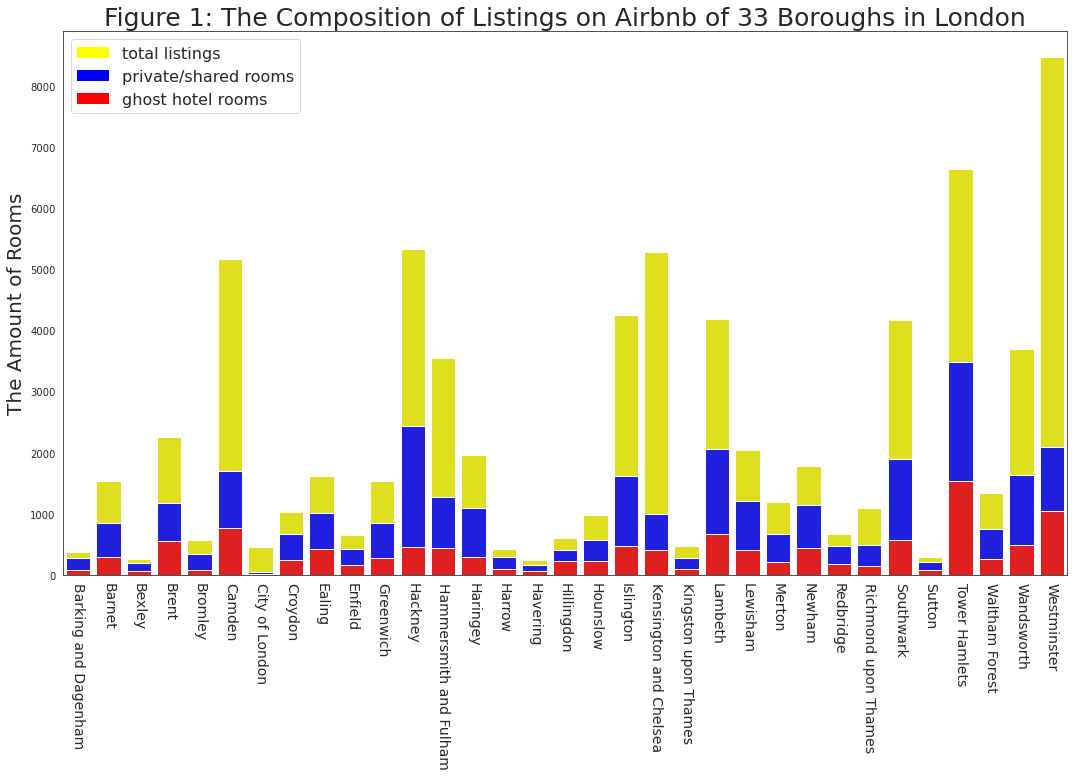

In [ ]:
stackFigure()

Figure 2 make up the limitation stated above. The dots represents the locations of the ghost hotels and dots with a larger size and lighter colour indicate a ghost hotel with more rooms. From which we can see most of them gather in the central part of London. For the outer boroughs, especially in the east part, have sparse listings distribution. The colours indicate the ghost hotel room rate (the number of ghost hotel rooms divided by the total number of listings on Airbnb) around London. The warm-toned colours represent the high ghost room rate, while the cold-toned colours represent the low one. It is supposed to see that Hillington has the highest ghost hotel room rate. In the rest of the artical, we will focus more on two specific areas, one is Hillington (regions with the highest ghost hotel room rate (37%)) and the other is Tower Hamlets boroughs (with the most ghost hotels (391) and rooms (1529)). Their enlarged views is on the left and right bottom of the plot. 

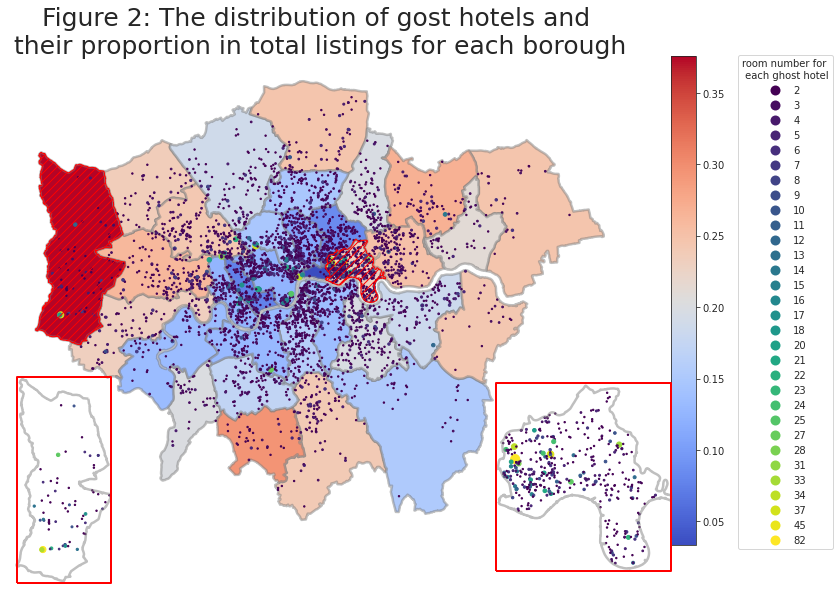

In [ ]:
mainPlot()

### Revenue from ghost hotel
The way to calculated hosts’ revenue refers the Inside Airbnb's "San Francisco Model". It uses a review rates of 50% to convert reviews to estimated bookings. As for the average stays, a value of 3 nights per booking was used if a listing has a lower minimum nights value than 3, otherwise use the minimum nights value. Therefore, the monthly avenue is "reviews per month x nights per booking x price" / 50%". Using this method, we can get that the total monthly avenue of all ghost hotels is more than 4 billion pound and account for about 9.7% of total listings' avenue in Airbnb. Additionally, 13.4% (around 440,000 pound) of the local avenue from listings is earned by ghost hotels for Tower Hamlets, and approximately 20% (just over forty thousand pound) for Hillingdon.

### Comparison with the long-term monthly rent
The violin plots show the density distribution of 3(a) the average monthly price of ghost hotels and one-bedroom rent in London and 3(b) the monthly ghost hotel price for two boroughs. Figure 3(a) shows that ghost hotels have more extensive prices interval than the long-term rental price.The median point of monthly ghost hotels price is about 1.5 times of one bedroom rent, while the largest point is more than 2 times larger than the rent. For two boroughs, We can see that the price for both Tower Hamlets and Hillington are mainly within $2,000. However, Tower Hamlets has more expensive ghost rooms since it is more prosperous and locates closely to the city of London. The red line on the two violin plots is the local average rent of one bedroom in traditional rental market, it is a little lower than the median prices of ghost hotels in Hillingdon but higher than that of Tower Hamlets.  

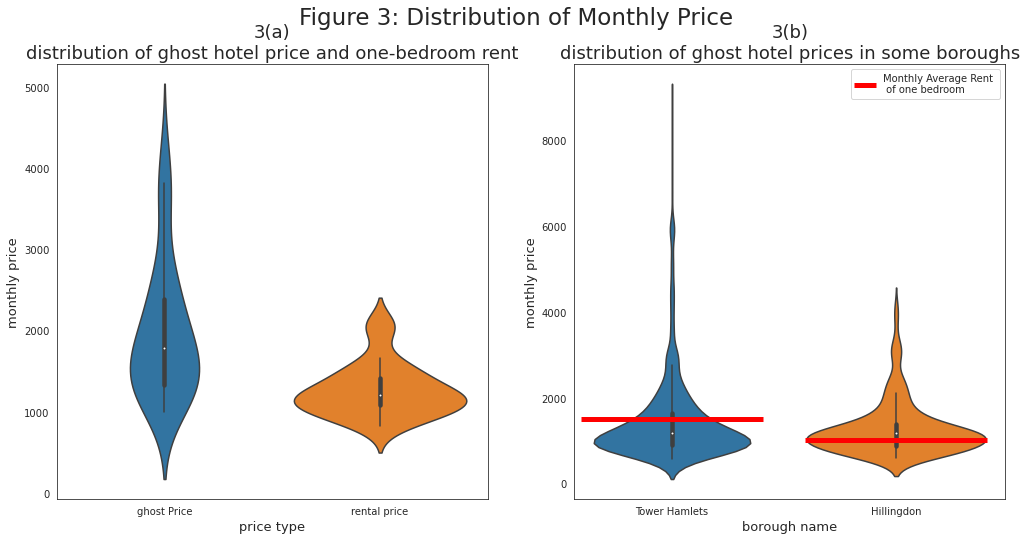

In [ ]:
densityPlot()

The mean of ghost room price in different areas is also calculated. Tower Hamlets is the only region whose average ghost room price is a little lower than the one-bedroom rent, Hillingdon's ghost room price is 1.24 times larger and a few regions is even more than three times larger than the one-bedroom rent. The gap we find is smaller than the finding of Alexandridis et al.(2020). He discovered that the mean accommodation price in Airbnb, which seems to be stabilized around $60–$65 per night or $1800–$2000 per month is at least 3 times higher that the average monthly long-term rental price in Athens. The reason may related to the mismatching of our data time. One-bedroom data from Valuation Office Agency (VOA) is updated bi-annually, so the newest data is in 2019, while the Airbnb data is crawled in 2020 and its price might be greatly influence by COVID-19.
### The Effect on the Rental Market
Ghost hotels in Airbnb not only beat the traditional hotels on price but the convenient location (Airbnb can operate in residential neighbourhoods while traditional hotels can't do so because of zoning restrictions). However, these "unregulated form of hotel operation" have been repeatedly labelled as unfair competition by tourism-related authorities and registered hotel owners (Alexandridis et al., 2020, p.7). 
In addition, existing of ghost hotel will further remove the rental stock of London's housing market (Wieditz, 2017). A multiple regression model whose response variable is the average monthly rent in LTR market(also from VOA), and dependent variables are average monthly price in Airbnb and the number of ghost hotels in 33 London borough. Our purpose is to test the relationship between the average rent in traditional rental market and number of ghost rooms. Our result shows, when the number of ghost rooms increase by 1, the monthly average rent will increase 0.35 pound. Combining with the findings from the researcher mentioned above. we can say, the ghost hotels' booming raises the prices long-term rent by the damping of long-term rental market. More and more long-term tenants in London can’t afford rent(Gant, 2016). 

### Suggestions and recommendation
One of the critical short-term-rental proposals is that the property should be inhabited by either the owner or tenant to prevent Airbnb from reducing already-scarce long-term-housing rental supply (Betsy Powell, 2017). This action could effectively reduce the housing impact caused by ghost hotels. However, it's hard to chase whether the host obeys this rule all the time. Gold (2019) think the current policies are ineffective and inconsistently applied, so the law must be reformed to prevent "hotelization" of residential neighbourhoods and better secure access to the affordable housing stock. Therefore, except limiting the available nights per year for all kinds of properties, taxes imposed could also be adjusted to be similar to the local hotel and convex tax should be induced to those who own more listings.
### Reference
Airbnb Help Centre. (no date). ‘Responsible hosting in the United Kingdom’. Available at: 
https://www.airbnb.co.uk/help/article/1379/responsible-hosting-in-the-united-kingdom#taxes.

Alexandridis, G., Voutos, Y., Mylonas, P. and Caridakis, G. (2020). ‘A geolocation analytics-driven ontology for short-term leases: Inferring current sharing economy trends’. Algorithms. MDPI AG, 13 (3), p. 59. doi: 10.3390/a13030059.

Barron, K., Kung, E. and Proserpio, D. (2018). ‘The Sharing Economy and Housing Affordability: Evidence from Airbnb’. SSRN Electronic Journal. doi: 10.2139/ssrn.3006832.

Betsy Powell. (2017). ‘City looks to rein in Airbnb as neighbours wait in worry; Absentee landlords, “ghost hotels,” loss of housing concern critics of unregulated short-term rentals’. Toronto star, p. GT1.

Dunn, T. (2017). ‘How to fix Toronto’s short-term rental problems in 2017’. CBC News, 3 January. Available at: http://www.cbc.ca/news/canada/toronto/airbnb-regulation-2017-1.3909369.

Emily Mathieu. (2017). ‘“Ghost” kings of Kensington play havoc with tenants; Renters say landlords are forcing them out and turning apartments into Airbnb “ghost hotels”’. Toronto star, p. A1.

Gant, A. C. (2016). ‘Holiday rentals: The new gentrification battlefront’. Sociological Research Online. University of Surrey, 21 (3). doi: 10.5153/sro.4071.

Gold, A. E. (2019). ‘Community consequences of airbnb’. Washington Law Review. Seattle: Washington Law Review Association, 94 (4), pp. 1577–1637.

Hamari, J., Sjöklint, M. and Ukkonen, A. (2016). ‘The sharing economy: Why people participate in collaborative consumption’. Journal of the Association for Information Science and Technology, 67 (9), pp. 2047–2059. doi: 10.1002/asi.23552.

Houlder, V. (2017). ‘Airbnb’s edge on room prices depends on tax advantages’. Financial Times. Available at: https://www.ft.com/content/73102c20-c60e-11e6-9043-7e34c07b46ef.

Raju Gajurel. (2018). ‘Tax on Airbnb Income’. Available at: https://www.ukpropertyaccountants.co.uk/tax-airbnb-income/.

Wachsmuth, D., Chaney, D., Kerrigan, D., Shillolo, A. and Basalaev-Binder, R. (2018). The high cost of short-term rentals in New York City.

Wieditz, T. (2017). ‘Squeezed Out: Airbnb’s Commercialization of Home-Sharing in Toronto’. Policy report prepared for FAIRBNB.CA Coalition.









### READ ME
The data file is large, and the calculations in the project is a little complex,so you may wait for more than 10 minutes.
What's more something might be wrong when runing(because of network and some system reason). When this happens, re-run the whole file
might be useful (in extreme cases, you might need to "vagrant halt" and "vagrant up" again. It happens for one time among more than 20 times' rerun).

Because of my fault, i submit the file in the last minute and then something is wrong with the moodle system. I emailed you and since i did not get the response from you (i guessed the result since you have told us not to submit in the last minutes, and it's totally my fault), i decided to try my best to perfect the work within 2 days (the penalty for one minutes and two days are the same, and that's why i submited one-day later).

Thanks for your hardwork for the last semester. I learned a lot from your teaching and hope you could be a little little proud of my work. Sorry again for the
late submission and hope to see you in reality!